<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C8N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = test.index % 5
test_add = test.loc[ mod != 0 ,:]
test_50 = test.loc[ mod == 0 ,:]
train = train.append(test_add)
test = test_50
print(train.shape)
print(test.shape)

(4721, 27)
(50, 27)


In [0]:
y_name = 'C8N'

# C8A與原始特徵相關係數

In [4]:
train.iloc[:,:4].join(train[y_name]).corr().loc[[y_name]]

,T10,T50,T90,N+A,C8N
C8N,-0.046063,-0.076231,-0.077099,0.676677,1.0


# C8A與其他Y相關係數

In [5]:
corr_res = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False)
corr_res.head(5).T

,C8N,C7N,C7NP,C9NP,C7IP
C8N,1.0,0.77208,0.639215,0.554186,0.552947


# def features & y_columns

In [6]:
features = ['T10','T50','T90','N+A']
y_columns = list(corr_res[corr_res[y_name]>0.8].index)
print(features)
print(y_columns)

['T10', 'T50', 'T90', 'N+A']
['C8N']


# PCA y_columns

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
pca = PCA(n_components=1)

train['PCA'] = pca.fit_transform(scaler_y.fit_transform(train[y_columns]))
test['PCA'] = pca.transform(scaler_y.transform(test[y_columns]))

# scaler features

In [0]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()

train[features] = scaler_x.fit_transform(train[features])
test[features] = scaler_x.transform(test[features])

# corr

In [9]:
train[features+['PCA']].corr()

,T10,T50,T90,N+A,PCA
T10,1.000000,0.895238,0.222087,-0.262210,-0.067388
T50,0.895238,1.000000,0.533778,-0.371996,-0.106584
T90,0.222087,0.533778,1.000000,-0.217989,-0.085853
N+A,-0.262210,-0.371996,-0.217989,1.000000,0.795104
PCA,-0.067388,-0.106584,-0.085853,0.795104,1.000000


# scatter

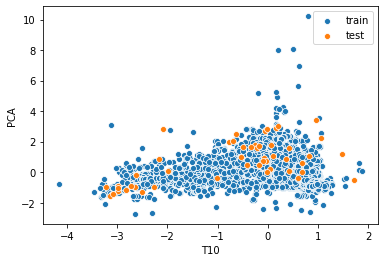

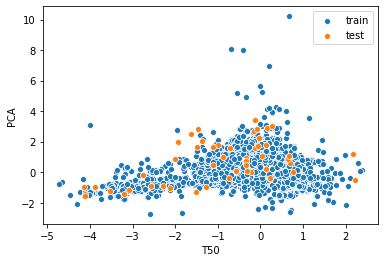

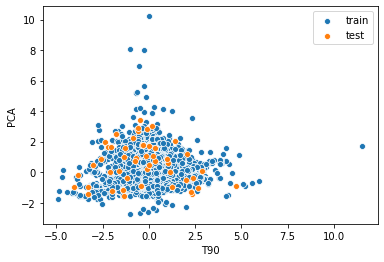

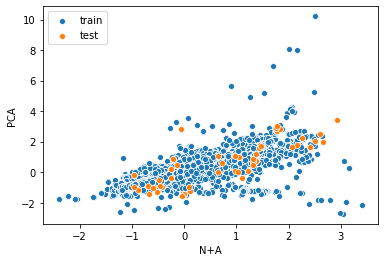

In [10]:
for x_col in features:
  sns.scatterplot(x=x_col,y='PCA',data=train,label='train')
  sns.scatterplot(x=x_col,y='PCA',data=test,label='test')
  plt.legend()
  plt.show()

# features select

In [0]:
features = ['N+A']

# features scaling

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[features].append(test[features]))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

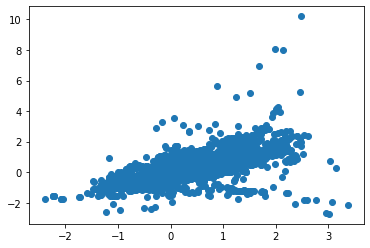

In [14]:
plt.scatter(train[features[-1]],train['PCA'])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [16]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression,ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
#model = SVR()
model = LinearRegression()
#model = ridge.Ridge()
#model = Lasso(alpha=0.01)

val_scores = cross_validate(model,train[features],train['PCA'],cv=5)

print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

# fit 
model.fit(train[features],train['PCA'])
# predict
test['y_pred'] = model.predict(test[features])
train['y_pred'] = model.predict(train[features])

val_scores: [-0.2877775   0.69287359  0.72856017  0.71069029  0.71486606]
val_scores.mean: 0.5118425219723048


In [17]:
print('train_scores:')
metric(train['PCA'],train['y_pred'])

train_scores:


,R2,RMSE,mean_absolute_error
PCA,0.63219,0.606473,0.334075


In [18]:
print('test_scores:')
metric(test['PCA'],test['y_pred'])

test_scores:


,R2,RMSE,mean_absolute_error
PCA,0.622839,0.848882,0.654211


# line plot

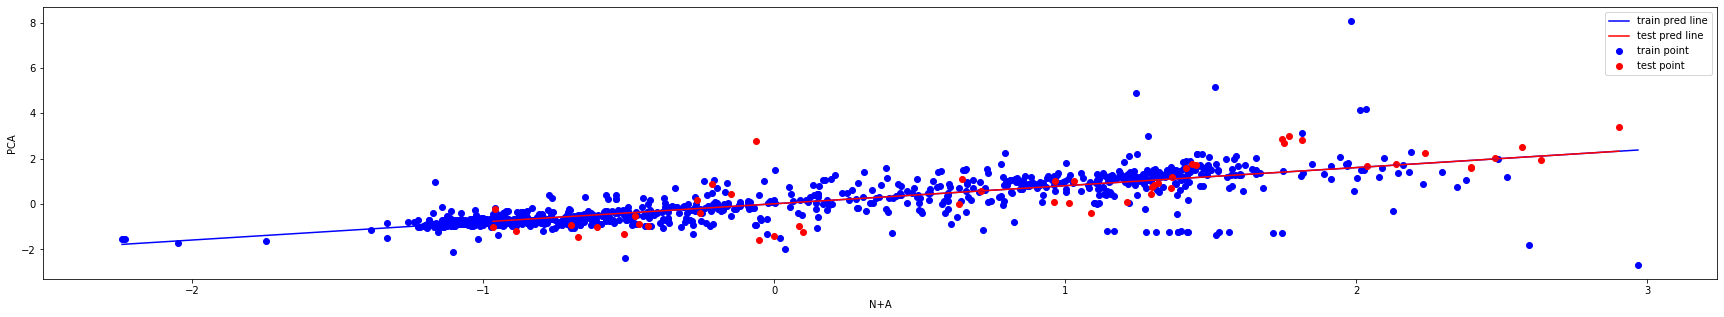

In [19]:
by_col = 'N+A'
fig = plt.figure(figsize=(30,5))
test_point = test.sort_values(by = by_col)
train_sample_point = train.sample(1000).sort_values(by = by_col)

plt.plot(train_sample_point[by_col],train_sample_point['y_pred'],label='train pred line',color='blue')
plt.scatter(train_sample_point[by_col],train_sample_point['PCA'],label='train point',color='blue')

plt.plot(test_point[by_col],test_point['y_pred'],label='test pred line',color='red')
plt.scatter(test_point[by_col],test_point['PCA'],label='test point',color='red')

plt.xlabel(by_col)
plt.ylabel('PCA')
plt.legend()
plt.show()

# check out

In [20]:
loss = (test_point['PCA'] - test_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
loss.head(5)

150    8.065890
235    2.498080
75     2.374362
225    2.166129
25     2.029526
dtype: float64

In [21]:
ub = loss.mean() + 1 * loss.std()
ub

1.995266117474912

In [22]:
out_index = list(loss[loss>ub].index)
out_index

[150, 235, 75, 225, 25]

# del out

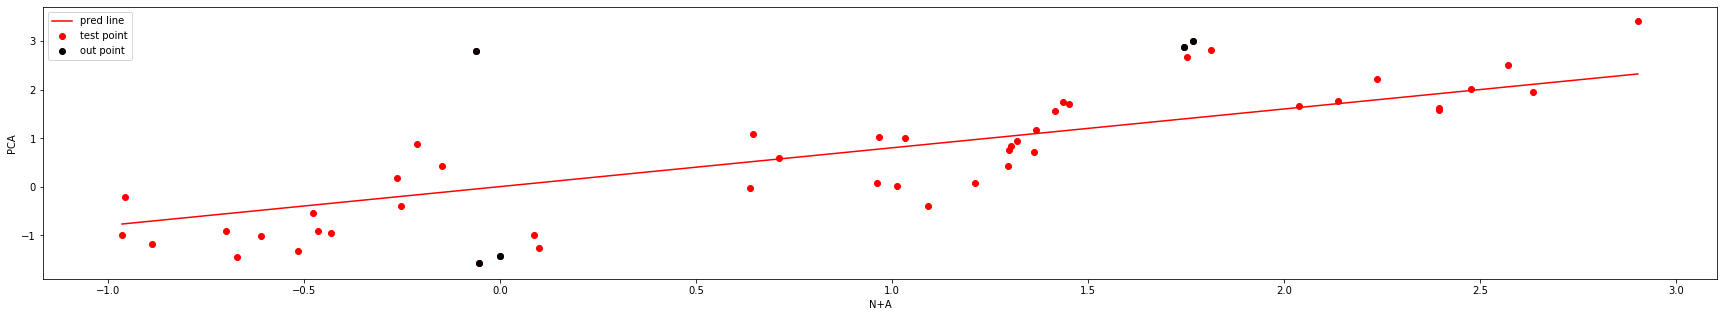

In [23]:
import numpy as np

#add out columns
test_point['out'] = False
test_point.loc[out_index,'out'] = True

#fig
fig = plt.figure(figsize=(30,5))

#sort test point
test_point = test_point.sort_values(by=by_col)

#def out_point
out_point = test_point[test_point['out'] == True]

#y_pred line
plt.plot(test_point[by_col],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point[by_col],test_point['PCA'],label='test point',color='red')

#out point
plt.scatter(out_point[by_col],out_point['PCA'],label='out point',color='black')

plt.xlabel(by_col)
plt.ylabel('PCA')
plt.legend()
plt.show()

# del_out_point_scores:

In [24]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,'PCA'],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
PCA,0.7343,0.648006,0.53006


# all scores

In [0]:
y_pred_all = pd.DataFrame(scaler_y.inverse_transform(pca.inverse_transform(test[['y_pred']])),index=test.index,columns=y_columns)
y_test_all = test[y_columns]

In [26]:
res = pd.DataFrame()
for i in y_columns:
  res = res.append(metric(y_test_all[i],y_pred_all[i]))
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C8N,0.622839,1.976682,1.523378
AVG,0.622839,1.976682,1.523378


# del out all scores

In [27]:
print(out_index)
y_pred_all = y_pred_all.drop(out_index,axis=0)
y_test_all = y_test_all.drop(out_index,axis=0)

[150, 235, 75, 225, 25]


In [28]:
res = pd.DataFrame()
for i in y_columns:
  res = res.append(metric(y_test_all[i],y_pred_all[i]))
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C8N,0.7343,1.508928,1.234282
AVG,0.7343,1.508928,1.234282


# plot

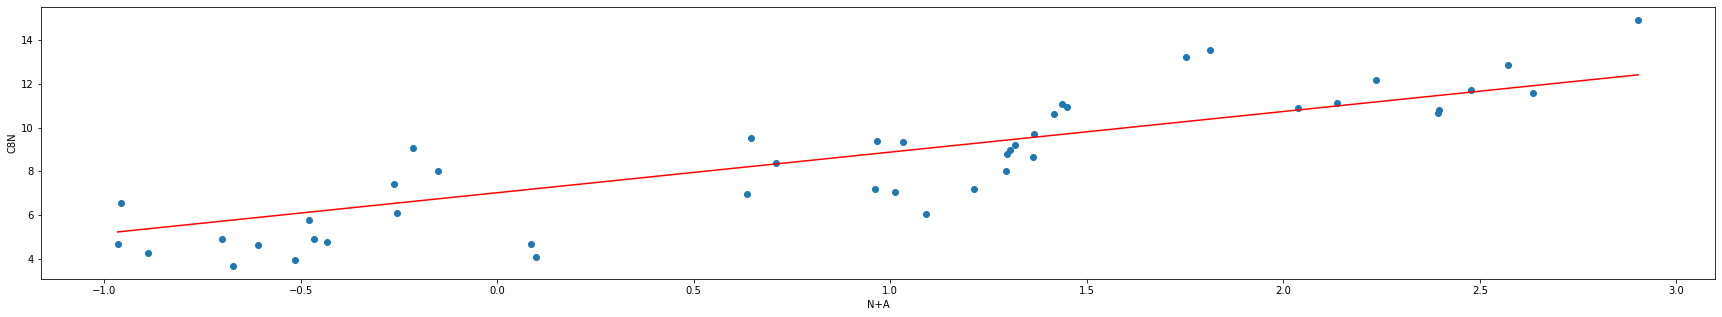

In [29]:
test_point = y_test_all.join(test['N+A']).sort_values(by='N+A')
pred_point = y_pred_all.join(test['N+A']).sort_values(by='N+A')
for i in y_columns:
  fig = plt.figure(figsize=(30,5))
  plt.scatter(test_point['N+A'],test_point[i])
  plt.plot(pred_point['N+A'],pred_point[i],color='red')
  plt.xlabel('N+A')
  plt.ylabel(i)
  plt.show()

# dump model

In [30]:
from sklearn.externals import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']

# 查看權重

In [36]:
model.coef_[0],model.intercept_

(0.7989996159685813, 0.007088172226973821)